# __Treino e testes da rede neural__
- Dataset: Guarujá (cap. 3)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

13 de junho de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
#https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

file = "ptos_aleatorios_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 
#dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "ptos_aleatorios.csv")))

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
#dataset.to_csv(os.path.join(APP_PATH, os.path.join("data", "ptos_aleatorios_shuffled.csv")))
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [8]:
#dataset["eng_1"] = dataset["Elevacao"] / dataset["Declividade"]

In [9]:
dataset.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataset = dataset[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
#dataset = dataset[['aspect','uso_solo','lito','twi','curv','class','eng_1']]
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [10]:
dataset.shape

(200, 8)

In [11]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,23.94,209.79,64.32,75.80,32.56,14.42,0.03,0.5
std,11.79,103.92,56.08,26.72,31.56,13.62,0.41,0.5
min,0.09,0.04,0.23,20.00,2.00,0.09,-0.59,0.0
25%,18.08,121.04,14.33,90.00,2.00,4.29,-0.01,0.0
50%,25.33,202.74,54.48,90.00,2.00,6.13,-0.00,0.0
75%,30.77,316.40,94.71,90.00,65.00,26.33,0.00,1.0
max,69.73,359.51,226.06,90.00,65.00,69.73,4.30,1.0


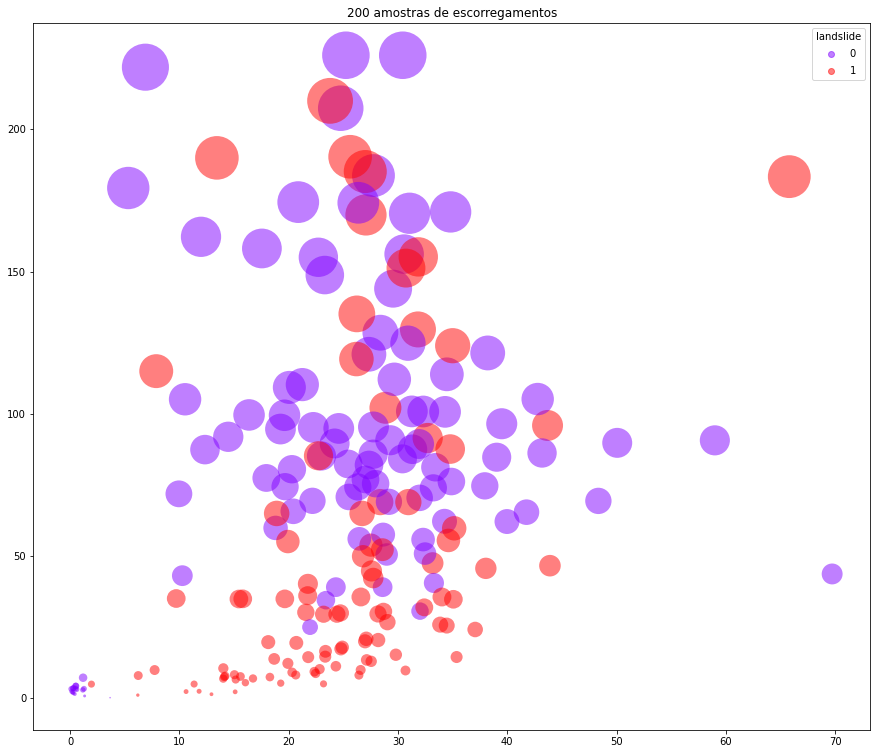

In [12]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' amostras de escorregamentos')) 

plt.show()

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- ref. https://realpython.com/train-test-split-python-data/
- Data Preparation With k-fold Cross-Validation

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das variáveis, bem como a identificação daquelas que podem ser removidas (vide analise análise da features).__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [13]:
#features menos relevantes guaruja
#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('uso_solo',axis=1)

# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [14]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [15]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [16]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [17]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [18]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [19]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [20]:
X.shape

(200, 7)

In [21]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [22]:
y.shape

(200, 1)

In [23]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [24]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [25]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

## Rede Neural Customizada
### Força Bruta para tuning dos hiperparametros 
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

In [26]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [27]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [28]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #camada de entrada
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por dropout e com inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#regularizacao por L2 e sem inicialização de pesos e bias
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,reg_func=l2_regularization,reg_strength=1e-2,activation=rna.relu))
#nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,dropout_prob = droput,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))        
    #camada de saída
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [29]:
#def setBestNeuralNetwork2(num_learning_rate,input_dim, output_dim):
#    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, patience=10) 

    #camada de entrada 
#    nn.layers.append(Layer(input_dim=input_dim, output_dim=20,activation= rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

#    nn.layers.append(Layer(input_dim=20, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=10, output_dim=10,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camadad de saída
#    nn.layers.append(Layer(input_dim=10, output_dim=output_dim,activation=rna.sigmoid))  

#    return nn

In [30]:
#def setBestNeuralNetwork3(num_learning_rate,input_dim, output_dim):
#    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate,momentum=0.25, patience=10) 

    #camada de entrada - considerar tanh na segunda camada e com dropout 0.2821478566400208
#    nn.layers.append(Layer(input_dim=input_dim, output_dim=7,activation= rna.relu, weights_initializer=rna.glorot_normal))

#    nn.layers.append(Layer(input_dim=7, output_dim=20 ,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
    #nn.layers.append(Layer(input_dim=7, output_dim=14,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
#    nn.layers.append(Layer(input_dim=20, output_dim=7,activation=rna.relu,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))
 
    #camada de saída
#    nn.layers.append(Layer(input_dim=7, output_dim=output_dim,activation=rna.sigmoid, weights_initializer=rna.glorot_normal))  

#    return nn

In [31]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 

neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [32]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Camada de Entrada: {} neurônios inputs  {} neurônios saída {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' _camada oculta {} neurônios {} camadas '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} neurônios da ultima camada oculta, {} neurônios na de saída \033[0m'.format(neurons,output_dim))

In [33]:
tot = 1
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    setTestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    tot += tot
                    #print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

print(tot)

 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 7 neurônios 1 camadas 
 7 neurônios da ultima camada oculta, 1 neurônios na de saída 
 Camada de Entrada: 7 neurônios inputs  7 neurônios saída 0.001 learning rate 
 _camada oculta 

In [34]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, {} dropout rate, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 1.00441122 + 0.00000000 = 1.00441122 loss_val = 1.00441122
epoch: 3000/40000 loss_train: 0.49496089 + 0.00000000 = 0.49496089 loss_val = 0.49496089
epoch: 6000/40000 loss_train: 0.37841754 + 0.00000000 = 0.37841754 loss_val = 0.37841754
epoch: 9000/40000 loss_train: 0.29563660 + 0.00000000 = 0.29563660 loss_val = 0.29563660
epoch: 12000/40000 loss_train: 0.23065208 + 0.00000000 = 0.23065208 loss_val = 0.23065208
epoch: 15000/40000 loss_train: 0.17272116 + 0.00000000 = 0.17272116 loss_val = 0.17272116
epoch: 18000/40000 loss_train: 0.12703779 + 0.00000000 = 0.12703779 loss_val = 0.12703779
epoch: 21000/40000 loss_train: 0.09965641 + 0.00000000 = 0.09965641 loss_val = 0.09965641
epoch: 24000/40000 loss_train: 0.08218509 + 0.00000000 = 0.08218509 loss_val = 0.08218509
epoch: 27000/40000 loss_train: 0.07029115 + 0.00000000 = 0.07029115 loss_val = 0.07029115
epoch: 30000/40000 loss_train: 0.06156106 + 0.00000000 = 0.06156106 loss_val = 0.06156106
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.25148674 + 0.00000000 = 0.25148674 loss_val = 0.25148674
epoch: 6000/40000 loss_train: 0.19172640 + 0.00000000 = 0.19172640 loss_val = 0.19172640
epoch: 9000/40000 loss_train: 0.15287514 + 0.00000000 = 0.15287514 loss_val = 0.15287514
epoch: 12000/40000 loss_train: 0.10983407 + 0.00000000 = 0.10983407 loss_val = 0.10983407
epoch: 15000/40000 loss_train: 0.06542798 + 0.00000000 = 0.06542798 loss_val = 0.06542798
epoch: 18000/40000 loss_train: 0.04251241 + 0.00000000 = 0.04251241 loss_val = 0.04251241
epoch: 21000/40000 loss_train: 0.03153312 + 0.00000000 = 0.03153312 loss_val = 0.03153312
epoch: 24000/40000 loss_train: 0.02501259 + 0.00000000 = 0.02501259 loss_val = 0.02501259
epoch: 27000/40000 loss_train: 0.02049926 + 0.00000000 = 0.02049926 loss_val = 0.02049926
epoch: 30000/40000 loss_train: 0.01711322 + 0.00000000 = 0.01711322 loss_val = 0.01711322
epoch: 33000/40000 loss_train: 0.01446340 + 0.00000000 = 0.01446340 loss_val = 0.01446340
epoch: 36000/

epoch: 9000/40000 loss_train: 0.02584292 + 0.00000000 = 0.02584292 loss_val = 0.02584292
epoch: 12000/40000 loss_train: 0.01786985 + 0.00000000 = 0.01786985 loss_val = 0.01786985
epoch: 15000/40000 loss_train: 0.01100330 + 0.00000000 = 0.01100330 loss_val = 0.01100330
Para 7 neurônios, 1 camadas,  0.01 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.72837379 + 0.00000000 = 0.72837379 loss_val = 0.72837379
epoch: 3000/40000 loss_train: 0.08863862 + 0.00000000 = 0.08863862 loss_val = 0.08863862
epoch: 6000/40000 loss_train: 0.07093535 + 0.00000000 = 0.07093535 loss_val = 0.07093535
epoch: 9000/40000 loss_train: 0.06219397 + 0.00000000 = 0.06219397 loss_val = 0.06219397
epoch: 12000/40000 loss_train: 0.05626096 + 0.00000000 = 0.05626096 loss_val = 0.05626096
epoch: 15000/40000 loss_train: 0.05020481 + 0.00000000 = 0.05020481 loss_val = 0.05020481
epoch: 18000/40000 loss_train: 0.04340363 + 0.00000000 = 0.04340363 loss_val = 0.04340

C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


Para 7 neurônios, 1 camadas,  0.01 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 57.14% 
epoch:    0/40000 loss_train: 0.82300393 + 0.00000000 = 0.82300393 loss_val = 0.82300393
epoch: 3000/40000 loss_train: 0.08522543 + 0.00000000 = 0.08522543 loss_val = 0.08522543
epoch: 6000/40000 loss_train: 0.06652748 + 0.00000000 = 0.06652748 loss_val = 0.06652748
epoch: 9000/40000 loss_train: 0.05379953 + 0.00000000 = 0.05379953 loss_val = 0.05379953
epoch: 12000/40000 loss_train: 0.04319563 + 0.00000000 = 0.04319563 loss_val = 0.04319563
epoch: 15000/40000 loss_train: 0.03376082 + 0.00000000 = 0.03376082 loss_val = 0.03376082
epoch: 18000/40000 loss_train: 0.02485824 + 0.00000000 = 0.02485824 loss_val = 0.02485824
epoch: 21000/40000 loss_train: 0.01755137 + 0.00000000 = 0.01755137 loss_val = 0.01755137
epoch: 24000/40000 loss_train: 0.01229100 + 0.00000000 = 0.01229100 loss_val = 0.01229100
epoch: 27000/40000 loss_train: 0.00908345 + 0.00000000 = 0.00908345 loss_val = 0.00908

epoch: 30000/40000 loss_train: 0.06258863 + 0.00000000 = 0.06258863 loss_val = 0.06258863
epoch: 33000/40000 loss_train: 0.05801191 + 0.00000000 = 0.05801191 loss_val = 0.05801191
epoch: 36000/40000 loss_train: 0.05437211 + 0.00000000 = 0.05437211 loss_val = 0.05437211
epoch: 39000/40000 loss_train: 0.05131045 + 0.00000000 = 0.05131045 loss_val = 0.05131045
Para 8 neurônios, 1 camadas,  0.001 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.86507000 + 0.00000000 = 0.86507000 loss_val = 0.86507000
epoch: 3000/40000 loss_train: 0.55430332 + 0.00000000 = 0.55430332 loss_val = 0.55430332
epoch: 6000/40000 loss_train: 0.42956415 + 0.00000000 = 0.42956415 loss_val = 0.42956415
epoch: 9000/40000 loss_train: 0.32164501 + 0.00000000 = 0.32164501 loss_val = 0.32164501
epoch: 12000/40000 loss_train: 0.26315508 + 0.00000000 = 0.26315508 loss_val = 0.26315508
epoch: 15000/40000 loss_train: 0.22703689 + 0.00000000 = 0.22703689 loss_val = 0.22703

epoch: 12000/40000 loss_train: 0.01623845 + 0.00000000 = 0.01623845 loss_val = 0.01623845
epoch: 15000/40000 loss_train: 0.01222788 + 0.00000000 = 0.01222788 loss_val = 0.01222788
epoch: 18000/40000 loss_train: 0.00933782 + 0.00000000 = 0.00933782 loss_val = 0.00933782
epoch: 21000/40000 loss_train: 0.00727028 + 0.00000000 = 0.00727028 loss_val = 0.00727028
epoch: 24000/40000 loss_train: 0.00578467 + 0.00000000 = 0.00578467 loss_val = 0.00578467
epoch: 27000/40000 loss_train: 0.00470761 + 0.00000000 = 0.00470761 loss_val = 0.00470761
epoch: 30000/40000 loss_train: 0.00390117 + 0.00000000 = 0.00390117 loss_val = 0.00390117
epoch: 33000/40000 loss_train: 0.00328872 + 0.00000000 = 0.00328872 loss_val = 0.00328872
epoch: 36000/40000 loss_train: 0.00281327 + 0.00000000 = 0.00281327 loss_val = 0.00281327
epoch: 39000/40000 loss_train: 0.00243893 + 0.00000000 = 0.00243893 loss_val = 0.00243893
Para 8 neurônios, 1 camadas,  0.01 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 97

epoch: 27000/40000 loss_train: 0.09850445 + 0.00000000 = 0.09850445 loss_val = 0.09850445
epoch: 30000/40000 loss_train: 0.08995465 + 0.00000000 = 0.08995465 loss_val = 0.08995465
epoch: 33000/40000 loss_train: 0.08349149 + 0.00000000 = 0.08349149 loss_val = 0.08349149
epoch: 36000/40000 loss_train: 0.07851636 + 0.00000000 = 0.07851636 loss_val = 0.07851636
Para 12 neurônios, 1 camadas,  0.001 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.67771983 + 0.00000000 = 0.67771983 loss_val = 0.67771983
epoch: 3000/40000 loss_train: 0.41636206 + 0.00000000 = 0.41636206 loss_val = 0.41636206
epoch: 6000/40000 loss_train: 0.31219109 + 0.00000000 = 0.31219109 loss_val = 0.31219109
epoch: 9000/40000 loss_train: 0.23737435 + 0.00000000 = 0.23737435 loss_val = 0.23737435
epoch: 12000/40000 loss_train: 0.16940990 + 0.00000000 = 0.16940990 loss_val = 0.16940990
epoch: 15000/40000 loss_train: 0.13226792 + 0.00000000 = 0.13226792 loss_val = 0.13

epoch: 12000/40000 loss_train: 0.06536478 + 0.00000000 = 0.06536478 loss_val = 0.06536478
epoch: 15000/40000 loss_train: 0.05740904 + 0.00000000 = 0.05740904 loss_val = 0.05740904
epoch: 18000/40000 loss_train: 0.04985790 + 0.00000000 = 0.04985790 loss_val = 0.04985790
epoch: 21000/40000 loss_train: 0.04295229 + 0.00000000 = 0.04295229 loss_val = 0.04295229
epoch: 24000/40000 loss_train: 0.03650878 + 0.00000000 = 0.03650878 loss_val = 0.03650878
epoch: 27000/40000 loss_train: 0.03067553 + 0.00000000 = 0.03067553 loss_val = 0.03067553
epoch: 30000/40000 loss_train: 0.02575629 + 0.00000000 = 0.02575629 loss_val = 0.02575629
epoch: 33000/40000 loss_train: 0.02139398 + 0.00000000 = 0.02139398 loss_val = 0.02139398
epoch: 36000/40000 loss_train: 0.01772132 + 0.00000000 = 0.01772132 loss_val = 0.01772132
epoch: 39000/40000 loss_train: 0.01478402 + 0.00000000 = 0.01478402 loss_val = 0.01478402
Para 12 neurônios, 1 camadas,  0.005 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 

C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


Para 12 neurônios, 1 camadas,  0.01 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 57.14% 
epoch:    0/40000 loss_train: 0.76173939 + 0.00000000 = 0.76173939 loss_val = 0.76173939
epoch: 3000/40000 loss_train: 0.05104752 + 0.00000000 = 0.05104752 loss_val = 0.05104752
epoch: 6000/40000 loss_train: 0.02764537 + 0.00000000 = 0.02764537 loss_val = 0.02764537
epoch: 9000/40000 loss_train: 0.01849600 + 0.00000000 = 0.01849600 loss_val = 0.01849600
epoch: 12000/40000 loss_train: 0.01301104 + 0.00000000 = 0.01301104 loss_val = 0.01301104
epoch: 15000/40000 loss_train: 0.00932987 + 0.00000000 = 0.00932987 loss_val = 0.00932987
epoch: 18000/40000 loss_train: 0.00692930 + 0.00000000 = 0.00692930 loss_val = 0.00692930
epoch: 21000/40000 loss_train: 0.00444913 + 0.00000000 = 0.00444913 loss_val = 0.00444913
Para 12 neurônios, 1 camadas,  0.01 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.74180091 + 0.00000000 = 0.74180091 

epoch: 21000/40000 loss_train: 0.07572280 + 0.00000000 = 0.07572280 loss_val = 0.07572280
epoch: 24000/40000 loss_train: 0.06723619 + 0.00000000 = 0.06723619 loss_val = 0.06723619
epoch: 27000/40000 loss_train: 0.06118029 + 0.00000000 = 0.06118029 loss_val = 0.06118029
epoch: 30000/40000 loss_train: 0.05619558 + 0.00000000 = 0.05619558 loss_val = 0.05619558
epoch: 33000/40000 loss_train: 0.05207018 + 0.00000000 = 0.05207018 loss_val = 0.05207018
epoch: 36000/40000 loss_train: 0.04856156 + 0.00000000 = 0.04856156 loss_val = 0.04856156
epoch: 39000/40000 loss_train: 0.04567131 + 0.00000000 = 0.04567131 loss_val = 0.04567131
Para 7 neurônios, 2 camadas,  0.001 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.90165826 + 0.00000000 = 0.90165826 loss_val = 0.90165826
epoch: 3000/40000 loss_train: 0.55134884 + 0.00000000 = 0.55134884 loss_val = 0.55134884
epoch: 6000/40000 loss_train: 0.37665051 + 0.00000000 = 0.37665051 loss_val = 0.37665

C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/40000 loss_train: 0.12772246 + 0.00000000 = 0.12772246 loss_val = 0.12772246
epoch: 6000/40000 loss_train: 0.07021093 + 0.00000000 = 0.07021093 loss_val = 0.07021093
epoch: 9000/40000 loss_train: 0.04617996 + 0.00000000 = 0.04617996 loss_val = 0.04617996
epoch: 12000/40000 loss_train: 0.03186296 + 0.00000000 = 0.03186296 loss_val = 0.03186296
Para 7 neurônios, 2 camadas,  0.005 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.73132326 + 0.00000000 = 0.73132326 loss_val = 0.73132326
epoch: 3000/40000 loss_train: 0.39044810 + 0.00000000 = 0.39044810 loss_val = 0.39044810
epoch: 6000/40000 loss_train: 0.21391969 + 0.00000000 = 0.21391969 loss_val = 0.21391969
epoch: 9000/40000 loss_train: 0.18238201 + 0.00000000 = 0.18238201 loss_val = 0.18238201
epoch: 12000/40000 loss_train: 0.11203475 + 0.00000000 = 0.11203475 loss_val = 0.11203475
epoch: 15000/40000 loss_train: 0.05793195 + 0.00000000 = 0.05793195 loss_val = 0.0579319

epoch: 18000/40000 loss_train: 0.00207966 + 0.00000000 = 0.00207966 loss_val = 0.00207966
epoch: 21000/40000 loss_train: 0.00144006 + 0.00000000 = 0.00144006 loss_val = 0.00144006
epoch: 24000/40000 loss_train: 0.00107129 + 0.00000000 = 0.00107129 loss_val = 0.00107129
epoch: 27000/40000 loss_train: 0.00083704 + 0.00000000 = 0.00083704 loss_val = 0.00083704
epoch: 30000/40000 loss_train: 0.00067868 + 0.00000000 = 0.00067868 loss_val = 0.00067868
epoch: 33000/40000 loss_train: 0.00056561 + 0.00000000 = 0.00056561 loss_val = 0.00056561
epoch: 36000/40000 loss_train: 0.00048159 + 0.00000000 = 0.00048159 loss_val = 0.00048159
epoch: 39000/40000 loss_train: 0.00041721 + 0.00000000 = 0.00041721 loss_val = 0.00041721
Para 7 neurônios, 2 camadas,  0.01 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.76256236 + 0.00000000 = 0.76256236 loss_val = 0.76256236
epoch: 3000/40000 loss_train: 0.13541091 + 0.00000000 = 0.13541091 loss_val = 0.13541

epoch: 18000/40000 loss_train: 0.15936535 + 0.00000000 = 0.15936535 loss_val = 0.15936535
epoch: 21000/40000 loss_train: 0.13539177 + 0.00000000 = 0.13539177 loss_val = 0.13539177
epoch: 24000/40000 loss_train: 0.11578235 + 0.00000000 = 0.11578235 loss_val = 0.11578235
epoch: 27000/40000 loss_train: 0.10008911 + 0.00000000 = 0.10008911 loss_val = 0.10008911
epoch: 30000/40000 loss_train: 0.08626797 + 0.00000000 = 0.08626797 loss_val = 0.08626797
epoch: 33000/40000 loss_train: 0.07454201 + 0.00000000 = 0.07454201 loss_val = 0.07454201
epoch: 36000/40000 loss_train: 0.06575518 + 0.00000000 = 0.06575518 loss_val = 0.06575518
epoch: 39000/40000 loss_train: 0.05766437 + 0.00000000 = 0.05766437 loss_val = 0.05766437
Para 8 neurônios, 2 camadas,  0.001 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 92.86% 
epoch:    0/40000 loss_train: 1.06771386 + 0.00000000 = 1.06771386 loss_val = 1.06771386
epoch: 3000/40000 loss_train: 0.15347676 + 0.00000000 = 0.15347676 loss_val = 0.15

epoch: 3000/40000 loss_train: 0.05693521 + 0.00000000 = 0.05693521 loss_val = 0.05693521
epoch: 6000/40000 loss_train: 0.01216826 + 0.00000000 = 0.01216826 loss_val = 0.01216826
epoch: 9000/40000 loss_train: 0.00560538 + 0.00000000 = 0.00560538 loss_val = 0.00560538
epoch: 12000/40000 loss_train: 0.00324013 + 0.00000000 = 0.00324013 loss_val = 0.00324013
epoch: 15000/40000 loss_train: 0.00215568 + 0.00000000 = 0.00215568 loss_val = 0.00215568
epoch: 18000/40000 loss_train: 0.00155680 + 0.00000000 = 0.00155680 loss_val = 0.00155680
epoch: 21000/40000 loss_train: 0.00111859 + 0.00000000 = 0.00111859 loss_val = 0.00111859
epoch: 24000/40000 loss_train: 0.00089075 + 0.00000000 = 0.00089075 loss_val = 0.00089075
epoch: 27000/40000 loss_train: 0.00073597 + 0.00000000 = 0.00073597 loss_val = 0.00073597
epoch: 30000/40000 loss_train: 0.00062250 + 0.00000000 = 0.00062250 loss_val = 0.00062250
epoch: 33000/40000 loss_train: 0.00053624 + 0.00000000 = 0.00053624 loss_val = 0.00053624
epoch: 36000/

epoch: 24000/40000 loss_train: 0.06493800 + 0.00000000 = 0.06493800 loss_val = 0.06493800
Para 12 neurônios, 2 camadas,  0.001 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 95.24% 
epoch:    0/40000 loss_train: 0.76058212 + 0.00000000 = 0.76058212 loss_val = 0.76058212
epoch: 3000/40000 loss_train: 0.52992960 + 0.00000000 = 0.52992960 loss_val = 0.52992960
epoch: 6000/40000 loss_train: 0.19949279 + 0.00000000 = 0.19949279 loss_val = 0.19949279
epoch: 9000/40000 loss_train: 0.12664239 + 0.00000000 = 0.12664239 loss_val = 0.12664239
epoch: 12000/40000 loss_train: 0.10246794 + 0.00000000 = 0.10246794 loss_val = 0.10246794
epoch: 15000/40000 loss_train: 0.09181488 + 0.00000000 = 0.09181488 loss_val = 0.09181488
epoch: 18000/40000 loss_train: 0.08519715 + 0.00000000 = 0.08519715 loss_val = 0.08519715
epoch: 21000/40000 loss_train: 0.08048735 + 0.00000000 = 0.08048735 loss_val = 0.08048735
epoch: 24000/40000 loss_train: 0.07696617 + 0.00000000 = 0.07696617 loss_val = 0.076

epoch: 3000/40000 loss_train: 0.10379480 + 0.00000000 = 0.10379480 loss_val = 0.10379480
epoch: 6000/40000 loss_train: 0.05329624 + 0.00000000 = 0.05329624 loss_val = 0.05329624
Para 12 neurônios, 2 camadas,  0.005 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.80425097 + 0.00000000 = 0.80425097 loss_val = 0.80425097
epoch: 3000/40000 loss_train: 0.05011882 + 0.00000000 = 0.05011882 loss_val = 0.05011882
epoch: 6000/40000 loss_train: 0.02050831 + 0.00000000 = 0.02050831 loss_val = 0.02050831
epoch: 9000/40000 loss_train: 0.00931386 + 0.00000000 = 0.00931386 loss_val = 0.00931386
epoch: 12000/40000 loss_train: 0.00493585 + 0.00000000 = 0.00493585 loss_val = 0.00493585
epoch: 15000/40000 loss_train: 0.00305953 + 0.00000000 = 0.00305953 loss_val = 0.00305953
epoch: 18000/40000 loss_train: 0.00210492 + 0.00000000 = 0.00210492 loss_val = 0.00210492
epoch: 21000/40000 loss_train: 0.00155262 + 0.00000000 = 0.00155262 loss_val = 0.00155

epoch: 15000/40000 loss_train: 0.06573922 + 0.00000000 = 0.06573922 loss_val = 0.06573922
epoch: 18000/40000 loss_train: 0.06126134 + 0.00000000 = 0.06126134 loss_val = 0.06126134
epoch: 21000/40000 loss_train: 0.05533230 + 0.00000000 = 0.05533230 loss_val = 0.05533230
epoch: 24000/40000 loss_train: 0.05314226 + 0.00000000 = 0.05314226 loss_val = 0.05314226
epoch: 27000/40000 loss_train: 0.05196285 + 0.00000000 = 0.05196285 loss_val = 0.05196285
epoch: 30000/40000 loss_train: 0.05111116 + 0.00000000 = 0.05111116 loss_val = 0.05111116
epoch: 33000/40000 loss_train: 0.05043740 + 0.00000000 = 0.05043740 loss_val = 0.05043740
epoch: 36000/40000 loss_train: 0.04986391 + 0.00000000 = 0.04986391 loss_val = 0.04986391
epoch: 39000/40000 loss_train: 0.04938365 + 0.00000000 = 0.04938365 loss_val = 0.04938365
Para 7 neurônios, 3 camadas,  0.001 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 90.48% 
epoch:    0/40000 loss_train: 1.20038328 + 0.00000000 = 1.20038328 loss_val = 1.200

C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


Para 7 neurônios, 3 camadas,  0.005 learning rate, 4 batch size, 0 dropout rate, temos:  Acurácia: 57.14% 
epoch:    0/40000 loss_train: 0.89784055 + 0.00000000 = 0.89784055 loss_val = 0.89784055
epoch: 3000/40000 loss_train: 0.26848381 + 0.00000000 = 0.26848381 loss_val = 0.26848381
epoch: 6000/40000 loss_train: 0.07578127 + 0.00000000 = 0.07578127 loss_val = 0.07578127
Para 7 neurônios, 3 camadas,  0.005 learning rate, 4 batch size, 0.1 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 1.00520568 + 0.00000000 = 1.00520568 loss_val = 1.00520568
epoch: 3000/40000 loss_train: 0.05922152 + 0.00000000 = 0.05922152 loss_val = 0.05922152
epoch: 6000/40000 loss_train: 0.02787597 + 0.00000000 = 0.02787597 loss_val = 0.02787597
epoch: 9000/40000 loss_train: 0.01451002 + 0.00000000 = 0.01451002 loss_val = 0.01451002
epoch: 12000/40000 loss_train: 0.00807362 + 0.00000000 = 0.00807362 loss_val = 0.00807362
epoch: 15000/40000 loss_train: 0.00501594 + 0.00000000 = 0.00501594 lo

epoch: 27000/40000 loss_train: 0.01712785 + 0.00000000 = 0.01712785 loss_val = 0.01712785
epoch: 30000/40000 loss_train: 0.01465340 + 0.00000000 = 0.01465340 loss_val = 0.01465340
epoch: 33000/40000 loss_train: 0.01276353 + 0.00000000 = 0.01276353 loss_val = 0.01276353
epoch: 36000/40000 loss_train: 0.01124917 + 0.00000000 = 0.01124917 loss_val = 0.01124917
epoch: 39000/40000 loss_train: 0.00999743 + 0.00000000 = 0.00999743 loss_val = 0.00999743
Para 8 neurônios, 3 camadas,  0.001 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.70541367 + 0.00000000 = 0.70541367 loss_val = 0.70541367
epoch: 3000/40000 loss_train: 0.66668514 + 0.00000000 = 0.66668514 loss_val = 0.66668514
epoch: 6000/40000 loss_train: 0.63693781 + 0.00000000 = 0.63693781 loss_val = 0.63693781
epoch: 9000/40000 loss_train: 0.55482633 + 0.00000000 = 0.55482633 loss_val = 0.55482633
epoch: 12000/40000 loss_train: 0.36401640 + 0.00000000 = 0.36401640 loss_val = 0.364016

epoch: 3000/40000 loss_train: 0.07402446 + 0.00000000 = 0.07402446 loss_val = 0.07402446
epoch: 6000/40000 loss_train: 0.02844914 + 0.00000000 = 0.02844914 loss_val = 0.02844914
epoch: 9000/40000 loss_train: 0.01372499 + 0.00000000 = 0.01372499 loss_val = 0.01372499
epoch: 12000/40000 loss_train: 0.00681622 + 0.00000000 = 0.00681622 loss_val = 0.00681622
epoch: 15000/40000 loss_train: 0.00382763 + 0.00000000 = 0.00382763 loss_val = 0.00382763
epoch: 18000/40000 loss_train: 0.00243936 + 0.00000000 = 0.00243936 loss_val = 0.00243936
epoch: 21000/40000 loss_train: 0.00170605 + 0.00000000 = 0.00170605 loss_val = 0.00170605
epoch: 24000/40000 loss_train: 0.00127171 + 0.00000000 = 0.00127171 loss_val = 0.00127171
epoch: 27000/40000 loss_train: 0.00099273 + 0.00000000 = 0.00099273 loss_val = 0.00099273
epoch: 30000/40000 loss_train: 0.00080225 + 0.00000000 = 0.00080225 loss_val = 0.00080225
epoch: 33000/40000 loss_train: 0.00066583 + 0.00000000 = 0.00066583 loss_val = 0.00066583
epoch: 36000/

C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\Projetos\python\dissertacao\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


Para 8 neurônios, 3 camadas,  0.01 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 57.14% 
epoch:    0/40000 loss_train: 0.68400817 + 0.00000000 = 0.68400817 loss_val = 0.68400817
epoch: 3000/40000 loss_train: 0.16483895 + 0.00000000 = 0.16483895 loss_val = 0.16483895
Para 8 neurônios, 3 camadas,  0.01 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.73762350 + 0.00000000 = 0.73762350 loss_val = 0.73762350
epoch: 3000/40000 loss_train: 0.42252063 + 0.00000000 = 0.42252063 loss_val = 0.42252063
epoch: 6000/40000 loss_train: 0.25149733 + 0.00000000 = 0.25149733 loss_val = 0.25149733
epoch: 9000/40000 loss_train: 0.13064208 + 0.00000000 = 0.13064208 loss_val = 0.13064208
epoch: 12000/40000 loss_train: 0.07155454 + 0.00000000 = 0.07155454 loss_val = 0.07155454
epoch: 15000/40000 loss_train: 0.05198642 + 0.00000000 = 0.05198642 loss_val = 0.05198642
epoch: 18000/40000 loss_train: 0.04187218 + 0.00000000 = 0.04187218 loss

Para 12 neurônios, 3 camadas,  0.005 learning rate, 0 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.80327062 + 0.00000000 = 0.80327062 loss_val = 0.80327062
epoch: 3000/40000 loss_train: 0.17896762 + 0.00000000 = 0.17896762 loss_val = 0.17896762
epoch: 6000/40000 loss_train: 0.05720749 + 0.00000000 = 0.05720749 loss_val = 0.05720749
Para 12 neurônios, 3 camadas,  0.005 learning rate, 0 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 
epoch:    0/40000 loss_train: 0.77222223 + 0.00000000 = 0.77222223 loss_val = 0.77222223
epoch: 3000/40000 loss_train: 0.23823615 + 0.00000000 = 0.23823615 loss_val = 0.23823615
epoch: 6000/40000 loss_train: 0.02372208 + 0.00000000 = 0.02372208 loss_val = 0.02372208
epoch: 9000/40000 loss_train: 0.00896341 + 0.00000000 = 0.00896341 loss_val = 0.00896341
epoch: 12000/40000 loss_train: 0.00462014 + 0.00000000 = 0.00462014 loss_val = 0.00462014
epoch: 15000/40000 loss_train: 0.00276734 + 0.00000000 = 0.00276734 

epoch: 27000/40000 loss_train: 0.00026382 + 0.00000000 = 0.00026382 loss_val = 0.00026382
epoch: 30000/40000 loss_train: 0.00022351 + 0.00000000 = 0.00022351 loss_val = 0.00022351
epoch: 33000/40000 loss_train: 0.00019294 + 0.00000000 = 0.00019294 loss_val = 0.00019294
epoch: 36000/40000 loss_train: 0.00016906 + 0.00000000 = 0.00016906 loss_val = 0.00016906
epoch: 39000/40000 loss_train: 0.00014997 + 0.00000000 = 0.00014997 loss_val = 0.00014997
Para 12 neurônios, 3 camadas,  0.01 learning rate, 8 batch size, 0 dropout rate, temos:  Acurácia: 100.00% 
epoch:    0/40000 loss_train: 0.95755964 + 0.00000000 = 0.95755964 loss_val = 0.95755964
epoch: 3000/40000 loss_train: 0.06770927 + 0.00000000 = 0.06770927 loss_val = 0.06770927
epoch: 6000/40000 loss_train: 0.01048244 + 0.00000000 = 0.01048244 loss_val = 0.01048244
Para 12 neurônios, 3 camadas,  0.01 learning rate, 8 batch size, 0.1 dropout rate, temos:  Acurácia: 97.62% 


In [35]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.001 de learning rate e 0 de batch size!


In [36]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann.acuracia,best_ann.ann))

100.00% foi a melhor acurácia, obtida com a rede <Rede_Neural.NeuralNetwork object at 0x0000023C5D03A940> 


In [37]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

57.14% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 4 de batch size e 0.1 dropout rate!
57.14% foi a melhor acurácia, obtida com 1 camadas,12 neurônios, 0.01 de learning rate, 4 de batch size e 0 dropout rate!
57.14% foi a melhor acurácia, obtida com 2 camadas,7 neurônios, 0.005 de learning rate, 0 de batch size e 0 dropout rate!
57.14% foi a melhor acurácia, obtida com 3 camadas,7 neurônios, 0.005 de learning rate, 4 de batch size e 0 dropout rate!
57.14% foi a melhor acurácia, obtida com 3 camadas,8 neurônios, 0.01 de learning rate, 8 de batch size e 0 dropout rate!
85.71% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.01 de learning rate, 4 de batch size e 0 dropout rate!
88.10% foi a melhor acurácia, obtida com 2 camadas,12 neurônios, 0.005 de learning rate, 0 de batch size e 0.1 dropout rate!
88.10% foi a melhor acurácia, obtida com 3 camadas,7 neurônios, 0.01 de learning rate, 4 de batch size e 0.1 dropout rate!
88.10% foi a melhor a

In [38]:
lst_hyperP = []
lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [39]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [40]:
#best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

In [41]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [42]:
#lst_hyperP = []
#lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,20,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [43]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [44]:
#best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

In [45]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

# Avaliação da rede Proprietária

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [46]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {:.2f} acc média {} RNA!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% foi a melhor acurácia, 99.17 acc média <Rede_Neural.NeuralNetwork object at 0x0000023C5D03A940> RNA!


In [47]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas,7 neurônios, 0.001 de learning rate, 0 de batch size e 0 dropout rate!


In [48]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [49]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [50]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [51]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 0 de batch size e 0 dropout rate!


In [52]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

98.33%, acurácia de teste !


In [53]:
bstANN = bestNN
#bst_hyper = bstANN.hyper
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% foi a melhor acurácia, obtida com 1 camadas, 0.001 de learning rate, 0 de batch size e 0 dropout rate!


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [54]:
if accu >= 85:
    print('{:.2f}%, ótima acurácia de teste, rede salva!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Acurácia: {:.2f}% acurácia de validação abaixo de .85!'.format(accu))

98.33%, ótima acurácia de teste, rede salva!


In [55]:
y_pred = bestNN.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 98.98%


In [56]:
y_pred = bestNN.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 100.00%


In [57]:
y_pred = bestNN.predict(X_test)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 98.33%


In [58]:
y_pred = bestNN.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 99.00%


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [59]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.98%


In [60]:
NetworkPerformance(y_train, yhat_probs)

Accuracy: 0.989796
Precision: 1.000000
Recall: 0.980769
F1 score: 0.990291
Cohens kappa: 0.979541
ROC AUC: 1.000000
[[46  0]
 [ 1 51]]


In [61]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 98.33%


In [62]:
NetworkPerformance(y_test, yhat_probs)

Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.991101
[[31  0]
 [ 1 28]]


In [63]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 100.00%


In [64]:
NetworkPerformance(y_val, yhat_probs)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [65]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 99.00%


In [66]:
NetworkPerformance(y, yhat_probs)

Accuracy: 0.990000
Precision: 1.000000
Recall: 0.979798
F1 score: 0.989796
Cohens kappa: 0.979994
ROC AUC: 0.997700
[[101   0]
 [  2  97]]


Área curva ROC=0.9977


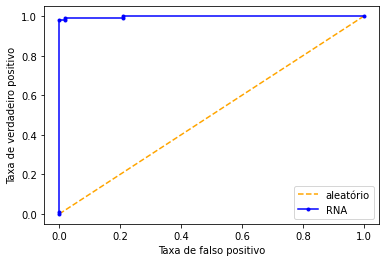

In [67]:
printAUROC(y,yhat_probs)

In [68]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

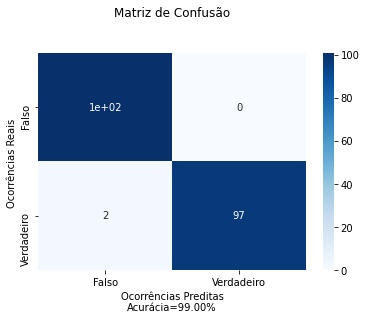

In [69]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de Confusão\n\n')
ax.set_xlabel('Ocorrências Preditas\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Ocorrências Reais ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Falso','Verdadeiro'])
ax.yaxis.set_ticklabels(['Falso','Verdadeiro'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [70]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

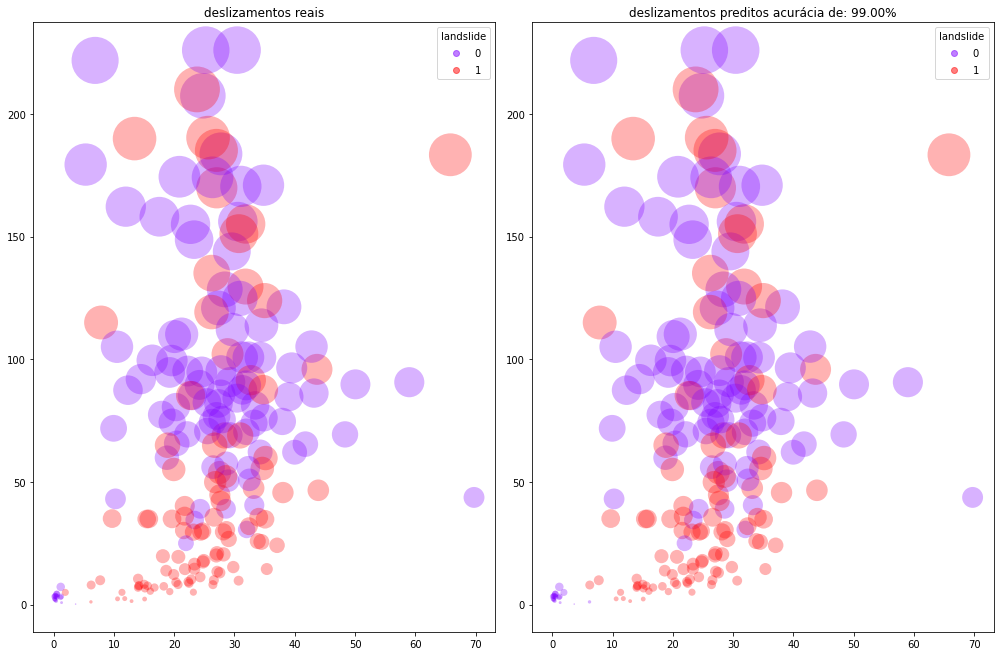

In [71]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [72]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [73]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [74]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Numero de Splits_stratified de X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [75]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [97.5, 100.0, 97.5, 100.0, 100.0, 100.0, 97.5, 100.0, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 97.5 %

Acurácia média: 99.0 %

Desvio Padrão: 1.2909944487358056


Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [76]:
dataset

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


In [77]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 99.00%


In [78]:
NetworkPerformance(y, y_pred)

Accuracy: 0.990000
Precision: 1.000000
Recall: 0.979798
F1 score: 0.989796
Cohens kappa: 0.979994
ROC AUC: 0.997700
[[101   0]
 [  2  97]]


In [79]:
output_proprietario

,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000143
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.995926
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000080
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,0.998912
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.168442
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,0.999997
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000084
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.010806
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000005


ROC AUC=0.998


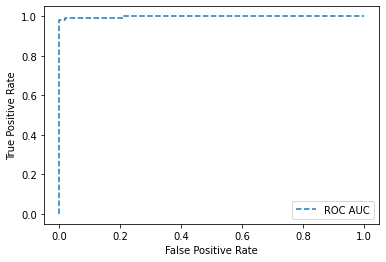

In [80]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

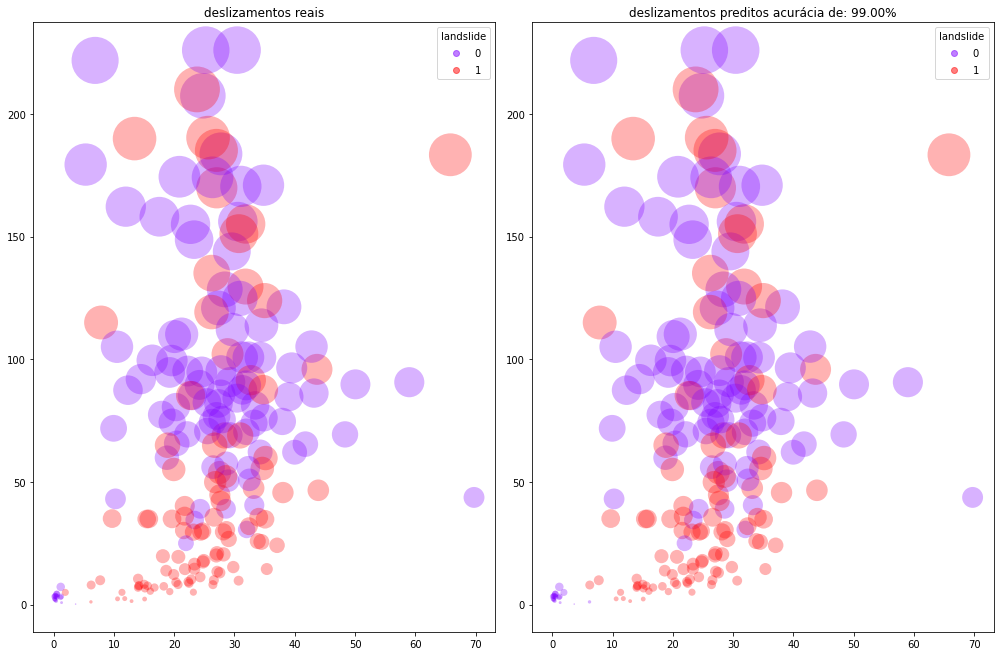

In [81]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


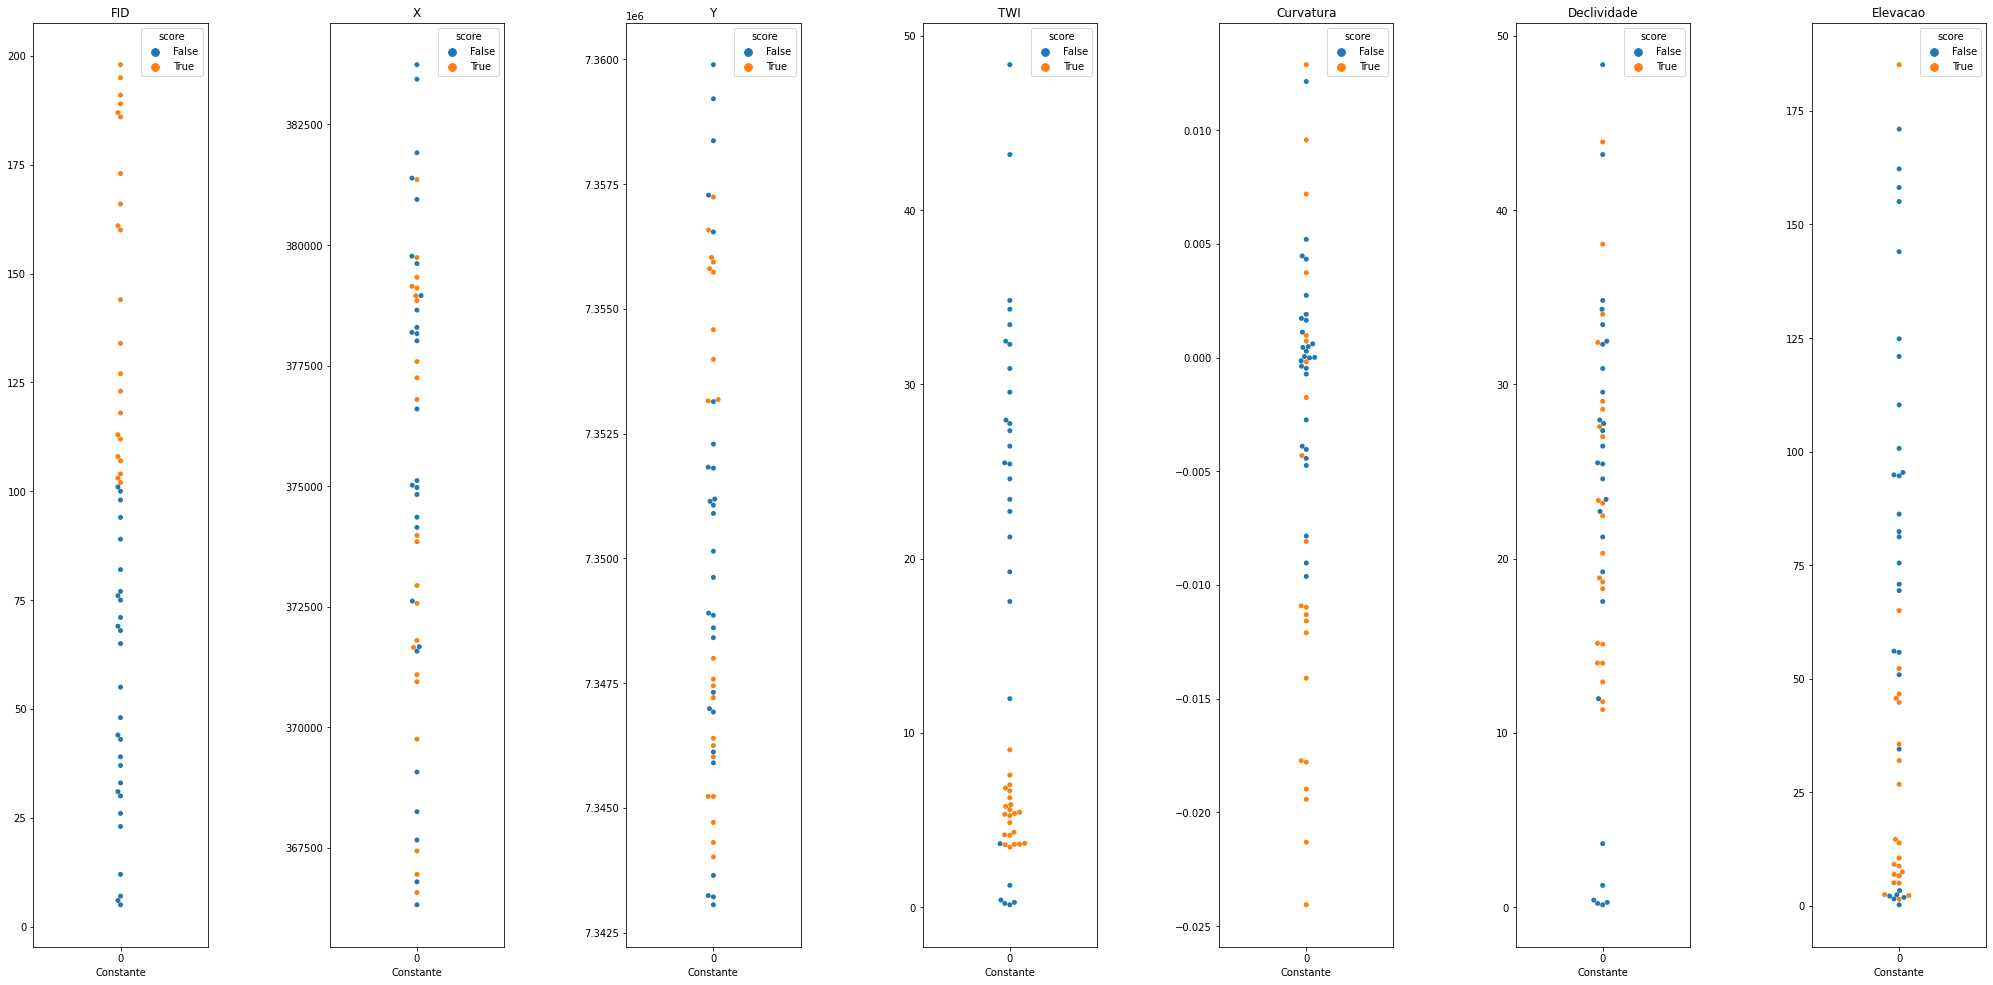

In [82]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [83]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [84]:
end = datetime.datetime.now()
print(end-start)
quit()

0:45:11.609109


## Rede Neural  Keras
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [85]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [86]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [87]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [88]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [89]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [90]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 0s 577us/step - loss: 0.7249 - accuracy: 0.5510
Epoch 2/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7157 - accuracy: 0.4796
Epoch 3/500
20/20 [==============================] - 0s 787us/step - loss: 0.6800 - accuracy: 0.5408
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.5918
Epoch 5/500
20/20 [==============================] - 0s 980us/step - loss: 0.6570 - accuracy: 0.5918
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6615 - accuracy: 0.6020
Epoch 7/500
20/20 [==============================] - 0s 787us/step - loss: 0.6355 - accuracy: 0.6939
Epoch 8/500
20/20 [==============================] - 0s 682us/step - loss: 0.6200 - accuracy: 0.6939
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6322 - accuracy: 0.6122
Epoch 10/500
20/20 [==============================] - 0s 682us/step - loss: 0.6224 - accuracy: 0.70

Epoch 82/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9592
Epoch 83/500
20/20 [==============================] - 0s 840us/step - loss: 0.1546 - accuracy: 0.9490
Epoch 84/500
20/20 [==============================] - 0s 630us/step - loss: 0.1653 - accuracy: 0.9286
Epoch 85/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.9592
Epoch 86/500
20/20 [==============================] - 0s 735us/step - loss: 0.1856 - accuracy: 0.9490
Epoch 87/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1674 - accuracy: 0.9490
Epoch 88/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 0.9388
Epoch 89/500
20/20 [==============================] - 0s 682us/step - loss: 0.1674 - accuracy: 0.9490
Epoch 90/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1682 - accuracy: 0.9388
Epoch 91/500
20/20 [==============================] - 0s 729us/step - loss: 0.1591 - accurac

20/20 [==============================] - 0s 577us/step - loss: 0.0751 - accuracy: 0.9796
Epoch 243/500
20/20 [==============================] - 0s 577us/step - loss: 0.0518 - accuracy: 0.9796
Epoch 244/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0548 - accuracy: 0.9898
Epoch 245/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9796
Epoch 246/500
20/20 [==============================] - 0s 945us/step - loss: 0.0785 - accuracy: 0.9592
Epoch 247/500
20/20 [==============================] - 0s 659us/step - loss: 0.0655 - accuracy: 0.9694
Epoch 248/500
20/20 [==============================] - 0s 525us/step - loss: 0.0631 - accuracy: 0.9796
Epoch 249/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0648 - accuracy: 0.9694
Epoch 250/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.9694
Epoch 251/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0521 - accuracy: 0

20/20 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9796
Epoch 403/500
20/20 [==============================] - 0s 682us/step - loss: 0.0486 - accuracy: 0.9796
Epoch 404/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9796
Epoch 405/500
20/20 [==============================] - 0s 787us/step - loss: 0.0423 - accuracy: 0.9898
Epoch 406/500
20/20 [==============================] - 0s 630us/step - loss: 0.0354 - accuracy: 0.9898
Epoch 407/500
20/20 [==============================] - 0s 579us/step - loss: 0.0508 - accuracy: 0.9796
Epoch 408/500
20/20 [==============================] - 0s 630us/step - loss: 0.0346 - accuracy: 0.9796
Epoch 409/500
20/20 [==============================] - 0s 631us/step - loss: 0.0419 - accuracy: 0.9796
Epoch 410/500
20/20 [==============================] - 0s 632us/step - loss: 0.0462 - accuracy: 0.9898
Epoch 411/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0318 - accurac

In [91]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 292


In [92]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.9667
Accuracy: 96.67


In [93]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/292
4/4 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9796
Epoch 2/292
4/4 [==============================] - 0s 5ms/step - loss: 0.0406 - accuracy: 0.9898
Epoch 3/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9796
Epoch 4/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9796
Epoch 5/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9796
Epoch 6/292
4/4 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9898
Epoch 7/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.9898
Epoch 8/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9796
Epoch 9/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 0.9898
Epoch 10/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9898
Epoch 11/292
4/4 [===========

4/4 [==============================] - 0s 983us/step - loss: 0.0417 - accuracy: 0.9898
Epoch 167/292
4/4 [==============================] - 0s 665us/step - loss: 0.0355 - accuracy: 0.9898
Epoch 168/292
4/4 [==============================] - 0s 4ms/step - loss: 0.0270 - accuracy: 0.9898
Epoch 169/292
4/4 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9898
Epoch 170/292
4/4 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 0.9898
Epoch 171/292
4/4 [==============================] - 0s 1ms/step - loss: 0.0276 - accuracy: 0.9898
Epoch 172/292
4/4 [==============================] - 0s 998us/step - loss: 0.0301 - accuracy: 0.9898
Epoch 173/292
4/4 [==============================] - 0s 997us/step - loss: 0.0313 - accuracy: 0.9898
Epoch 174/292
4/4 [==============================] - 0s 997us/step - loss: 0.0305 - accuracy: 0.9898
Epoch 175/292
4/4 [==============================] - 0s 665us/step - loss: 0.0317 - accuracy: 0.9898
Epoch 176/29

In [94]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 997us/step - loss: 0.1087 - accuracy: 0.9667
Accuracy: 96.67


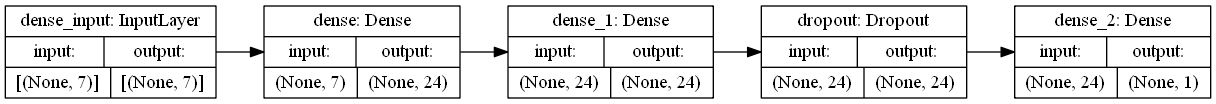

In [95]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [96]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

ótima acurácia, rede salva!
INFO:tensorflow:Assets written to: bestANN\suscetibilidadeKeras_guaruja.pkl\assets


# Avaliação da rede keras

In [97]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [98]:
#X

In [99]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Numero de Splits de X:  10 



In [100]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [97.5, 100.0, 95.0, 100.0, 100.0, 100.0, 97.5, 97.5, 97.5, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 98.5 %

Desvio Padrão: 1.7480147469502525


In [101]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 96.67%


In [102]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 98.98%


In [103]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 100.00%


In [104]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 98.50%


In [105]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,FID,X,Y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class,score
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0,0.000035
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1,0.999997
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0,0.000052
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1,1.000000
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0,0.053349
...,...,...,...,...,...,...,...,...,...,...,...,...
195,176,380247.0000,7355075.000,3.111852,0.009217,65.807915,183.386307,335.578705,65,90,1,1.000000
196,25,371328.0618,7346102.434,34.884327,-0.003104,34.884327,76.214539,335.742798,2,90,0,0.000207
197,47,375938.4356,7349522.181,16.367725,0.009234,16.367725,99.617256,167.967239,2,90,0,0.008488
198,87,379277.9602,7354447.102,30.434063,0.000543,30.434063,226.055237,155.315613,65,90,0,0.000004


ROC AUC=0.997


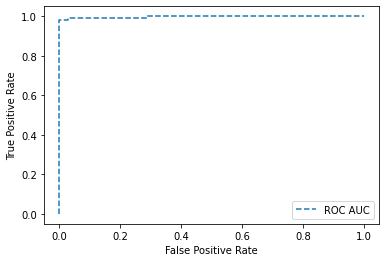

In [106]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

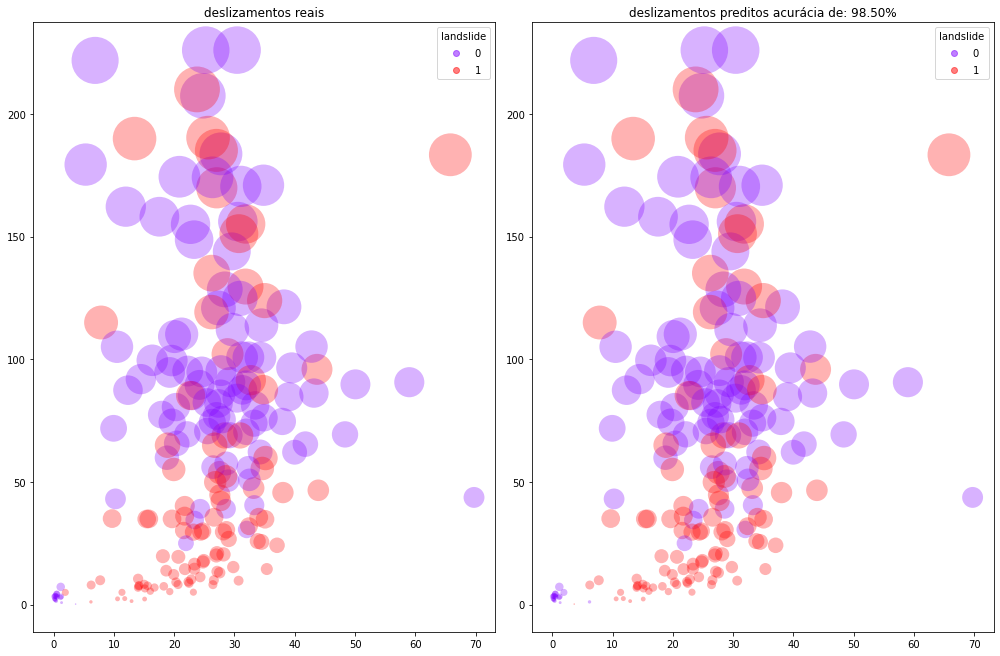

In [107]:
sizes = output_proprietario['Elevacao']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['Declividade'], output_proprietario['Elevacao'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


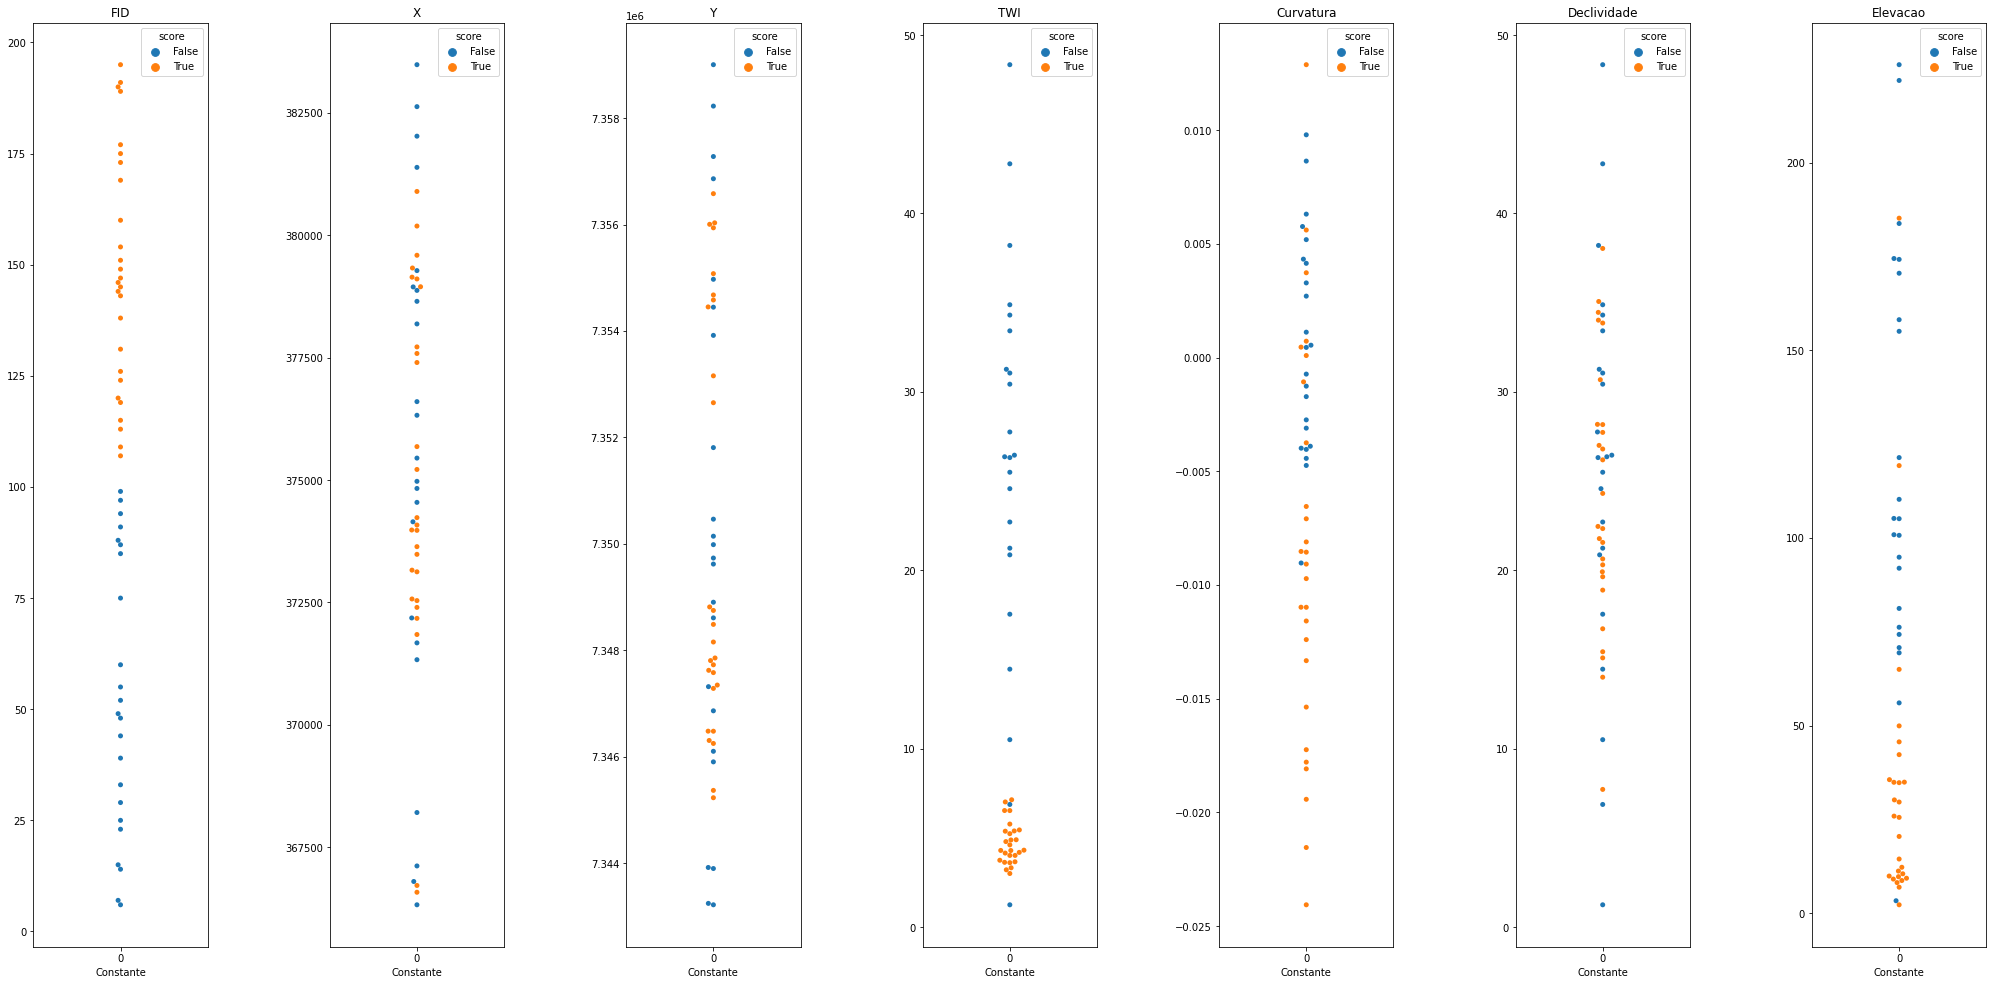

In [108]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [109]:
end = datetime.datetime.now()
print(end-start)

0:46:47.621006
